In [1]:
# Imports
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, TimeDistributed, Masking
from tensorflow.keras.optimizers import Adam

2023-09-26 15:03:15.480434: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-26 15:03:15.527916: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-26 15:03:15.528722: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 15:03:16.180395: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Read the dataset as text
with open("/home/pedranji/Projects/RNNs/Datasets/ner/wikigold/wikigold.conll.txt", 'r', encoding='utf-8') as file:
    dataset_text = file.read()

# Pre-process the dataset to remove trailing "\n" characters
lines = dataset_text.strip().split('\n')
lines = [line.rstrip('\n') for line in lines]

data = []
for line in lines:
    row = line.split(' ')
    data.append(row)

df = pd.DataFrame(data, columns=['Token', 'Entity'])


In [3]:
# remove nan
df = df.dropna().reset_index(drop=True)

# Split "double words". these words are two words joined by a - character. I want them in separated rows.
# Example: "New-York" -> ["New", "York"]
df['Token'] = df['Token'].apply(lambda x: x.split('-') if '-' in x else x)

# Explode the dataframe to have one word per row. This will separate all elements of rows that have a list.
df["Token"] = df["Token"].explode().reset_index(drop=True)


In [4]:
# drop all "-DOCSTART-" tokens
df = df[~df['Token'].isin(['-DOCSTART-', 'DOCSTART'])]

# Drop all "" values
df = df[df['Token'] != ''].reset_index(drop=True)


In [24]:
# Set Labels

# map the labels to numbers
labels = df["Entity"].unique()
label_to_index = {} 
index_to_label = {}
for i, label in enumerate(labels):
    label_to_index[label] = i
    index_to_label[i] = label

df["Label"] = df["Entity"].map(label_to_index)
print(label_to_index)

{'I-MISC': 0, 'O': 1, 'I-ORG': 2, 'I-PER': 3, 'I-LOC': 4}


In [6]:
# I think this assigns one number to each word.
def get_dict_map(data):
    tok2idx = {}
    idx2tok = {}
    
    vocab = list(set(data.to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(df["Token"])

df["Embeddings"] = df["Token"].map(token2idx)

In [7]:
# Create Sentence # Column

# This function will count the number of sentences in the dataset.
def get_sentence_number(data):
    sentence_number = 1
    sentence_number_list = []
    for word in data:
        if word == ".":
            sentence_number += 1
        sentence_number_list.append(sentence_number)
    return sentence_number_list

df["Sentence #"] = get_sentence_number(df["Token"])
df.head()

,Token,Entity,Label,Embeddings,Sentence #
0,010,I-MISC,0,4711,1
1,is,O,1,3204,1
2,the,O,1,5894,1
3,tenth,O,1,3572,1
4,album,O,1,3015,1


In [8]:
# Remove every row that is a "." in the token column
df = df[df["Token"] != "."].reset_index(drop=True)

In [9]:
# group by sentence number and join tokens into a sentence
df_grouped = df.groupby('Sentence #').agg({'Token': list, 'Label': list, "Embeddings": list}).reset_index()

df_grouped.head()

,Sentence #,Token,Label,Embeddings
0,1,"[010, is, the, tenth, album, from, Japanese, P...","[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 2, 2]","[4711, 3204, 5894, 3572, 3015, 4145, 7722, 403..."
1,2,"[This, album, proved, to, be, more, commercial...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...","[7067, 3015, 4311, 7990, 7374, 930, 5071, 8131..."
2,3,"[Founding, member, Kojima, Minoru, played, gui...","[3, 3, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, ...","[5632, 2541, 7750, 4024, 2429, 215, 7525, 2475..."
3,4,"[XXX, can, of, This, had, a, different, meanin...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3544, 6814, 6317, 7067, 5918, 1520, 7909, 358..."
4,5,"[it, was, later, explained, that, the, song, w...","[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...","[6931, 2225, 3234, 4361, 2556, 5894, 1493, 222..."


In [10]:
# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_grouped['Token'].values)
word_index = tokenizer.word_index

In [11]:
# FastText word embeddings
import fasttext
import numpy as np

# Load the trained FastText model
model = fasttext.load_model('FastText.bin')

# Create the embedding matrix
embedding_matrix = np.zeros((len(token2idx)+1, 100)) # 100 is the dimension of each embedding
for word, i in word_index.items():
    embedding_matrix[i] = model.get_word_vector(word)

df_grouped["Embeddings_FastText"] = df_grouped["Embeddings"].map(lambda x: embedding_matrix[x])



In [12]:
# Useful variables
n_words = len(set(df['Token'].explode().to_list()))+1 # why the +1?
output_dim = 100
lengths = df_grouped['Token'].apply(len)
input_length = 98 # arbitrary number, max was 144 but was too much and only one case.
n_classes = len(set(df['Label'].to_list()))

print("Number of words: ", n_words)
print("Output dimensions: ", output_dim)
print("Input length: ", input_length)
print("Number of classes: ", n_classes)



Number of words:  8263
Output dimensions:  100
Input length:  98
Number of classes:  5


In [14]:
# PRE PROCESS X
X = df_grouped["Embeddings_FastText"].to_list()

# manual padding
for i in range(len(X)):
    while len(X[i]) < input_length: # 98
        X[i] = np.append(X[i], np.zeros((1,100)), axis=0)

# truncate the results to 98 input length
X = pad_sequences(X, maxlen=input_length, padding='post', truncating="post", dtype='float32')

In [16]:
# PRE PROCESS Y
from tensorflow.keras.utils import to_categorical

# One-Hot encode the labels
y = df_grouped['Label'].values
y = [to_categorical(i, num_classes=n_classes) for i in y]

for i in range(len(y)):
    while len(y[i]) < input_length: # 98
        y[i] = np.append(y[i], [[1, 0, 0, 0, 0]], axis=0)


# truncate the results to 98 input length
y = pad_sequences(y, maxlen=input_length, padding='post', truncating="post", dtype='float32')

In [17]:
# Train Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, shuffle=True, test_size=0.5)

In [18]:
# To tensors
from tensorflow import convert_to_tensor
import tensorflow as tf

X_train_tensor = convert_to_tensor(X_train)
y_train_tensor = convert_to_tensor(y_train)
X_val_tensor = convert_to_tensor(X_val)
y_val_tensor = convert_to_tensor(y_val)
X_test_tensor = convert_to_tensor(X_test)
y_test_tensor = convert_to_tensor(y_test)


X_train_tensor:  False
y_train_tensor:  False
X_val_tensor:  False
y_val_tensor:  False
X_test_tensor:  False
y_test_tensor:  False


2023-09-26 15:03:19.696304: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-26 15:03:19.696850: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


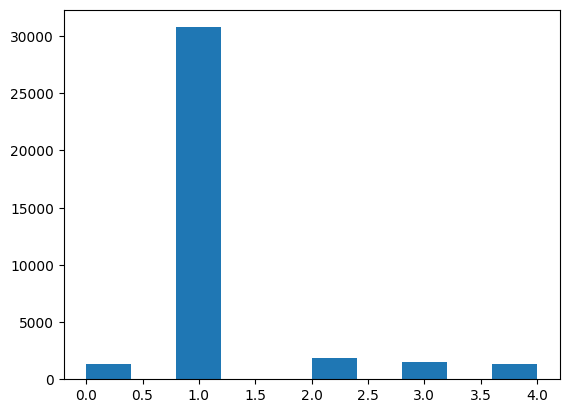

In [40]:
# check dataset distribution
import matplotlib.pyplot as plt

plt.hist(df_grouped['Label'].explode().to_list())
plt.show()

In [51]:
# Get weights for each class
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(df['Label'].to_list()), y=df['Label'].to_list())
class_weights_normalized = class_weights / np.sum(class_weights)

class_weights_by_hand = [3.6440184, 0.23917975, 3.98257576, 4.82293578, 5.4517037]
class_weights_by_hand_normalized = class_weights_by_hand / np.sum(class_weights_by_hand)

# define weighted categorical crossentropy
from tensorflow.keras import backend as K

def weighted_categorical_crossentropy(weights):
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calculate loss
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [53]:
# define the model
rnn = Sequential()

rnn.add(Masking(mask_value=0.0, input_shape=(input_length, output_dim), name="Input_Layer"))

rnn.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.5)))

rnn.add(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.5))

rnn.add(TimeDistributed(Dense(n_classes, activation="softmax", name="Output_Layer")))

adam = Adam(beta_1=0.9, beta_2=0.999, clipnorm=1.0)

rnn.compile(loss=weighted_categorical_crossentropy(class_weights_by_hand_normalized), optimizer=adam, metrics=['accuracy'])

In [54]:
rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (Masking)       (None, 98, 100)           0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 98, 200)           160800    
 onal)                                                           
                                                                 
 lstm_7 (LSTM)               (None, 98, 100)           120400    
                                                                 
 time_distributed_3 (TimeDi  (None, 98, 5)             505       
 stributed)                                                      
                                                                 
Total params: 281705 (1.07 MB)
Trainable params: 281705 (1.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
H = rnn.fit(X_train_tensor, y_train_tensor, validation_data=(X_val_tensor, y_val_tensor), epochs=30, verbose=1)


Epoch 1/30
35/35 [==============================] - 9s 135ms/step - loss: 0.0820 - accuracy: 0.2483 - val_loss: 0.0801 - val_accuracy: 0.8416
Epoch 2/30
35/35 [==============================] - 4s 115ms/step - loss: 0.0819 - accuracy: 0.1701 - val_loss: 0.0799 - val_accuracy: 0.0472
Epoch 3/30
35/35 [==============================] - 4s 119ms/step - loss: 0.0818 - accuracy: 0.5377 - val_loss: 0.0800 - val_accuracy: 0.0472
Epoch 4/30
35/35 [==============================] - 4s 114ms/step - loss: 0.0815 - accuracy: 0.0478 - val_loss: 0.0800 - val_accuracy: 0.0472
Epoch 5/30
35/35 [==============================] - 4s 115ms/step - loss: 0.0815 - accuracy: 0.0514 - val_loss: 0.0800 - val_accuracy: 0.0472
Epoch 6/30
35/35 [==============================] - 4s 114ms/step - loss: 0.0816 - accuracy: 0.2098 - val_loss: 0.0799 - val_accuracy: 0.0472
Epoch 7/30
35/35 [==============================] - 4s 114ms/step - loss: 0.0817 - accuracy: 0.0691 - val_loss: 0.0799 - val_accuracy: 0.5640
Epoch 

In [56]:
# predictions

y_pred = rnn.predict(X_test_tensor)
y_pred = np.argmax(y_pred, axis=-1)

8/8 [==============================] - 1s 33ms/step


In [57]:
np.unique(y_pred)

array([1, 2, 3, 4])

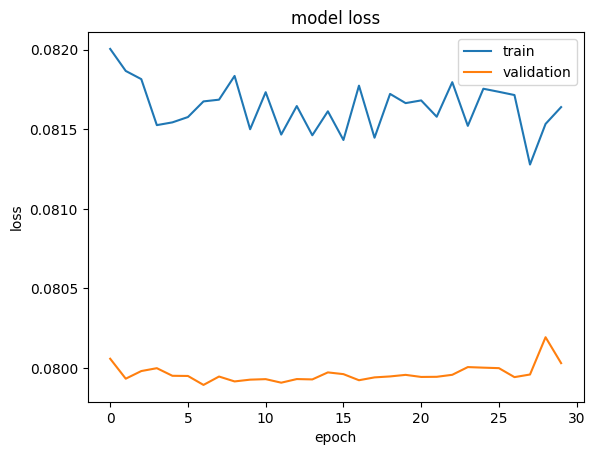

In [58]:
# show graphs for loss
import matplotlib.pyplot as plt

plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()